# Word Embedding Tutorial

## What you can expect from this tutorial
At the end of this notebook, you'll have an understanding of
- what is a word vector, and why do I need one?
- how to get word vectors
    - distributional semantics: simple counts
    - word embeddings: neural methods
- how to use word embeddings
    - finding similar terms
    - combining concepts and searching for terms between them, "more like me"
    - using negative examples to complete analogy questions (sometimes)

## What's out-of-scope for this tutorial?
You won't learn about
- different methods for training neural word embeddings
    - CBOW/Skip-gram
    - Word2Vec
    - How FastText works
- Using word embeddings for downstream classification tasks
- Measuring the goodness of your embedding model
    - detecting unethical bias in your model
    - comparing one word embedding model to another to determine which is better

In [1]:
# let's start a dictionary so we can store definitions for words we don't know
d = {}

## Why do we need word vectors?
Remember feature vectors? We have this list of numbers that represents an instance of data. This numerical representation allows us to make predictions using predictive modeling algorithms. 

Consider the feature vectors for cars.

|   instances   | is_red      | has_4_wheel_drive | label |
| ------------- | ----------- | ----------- | ---------|
| instance_1    | 0           | 1 | truck |
| instance_2    | 1           | 0 | car |

A word vector is a way to represent the features of this word and (maybe) use in a downstream modeling task. Word vectors allow us to represent the meaning of a word numerically. With this vector represation of a word's semantics, we can easily give this information to predictive models.

A word vector might look like this

|   words   | appeared_near_yum      | appeared_near_red |
| ------------- | ----------- | ----------- |
| apple    | 1           | 1 |
| applesauce    | 1           | 0 |
| firetruck | 0 | 1 |

This is in accordance with the hypothesis of [distributional semantics](https://en.wikipedia.org/wiki/Distributional_semantics#:~:targetText=Distributional%20semantics%20is%20a%20research,large%20samples%20of%20language%20data.): _linguistic items with similar distributions have similar meanings_

A _word vector_ uses the distributional hypothesis. Each word vector represents a word with a very high-dimensional sparse vector, where each dimension reflects a context in which the word occurred in the corpus. For example, a context could be another word that appeared in proximity.

A _word embedding_ represents a word with a low-dimensional vector (e.g. 100 dimensions). The dimensions are usually latent, and often obtained using the information as in the distributional semantics approach (e.g. LSA, word2vec). ([source](https://www.quora.com/Whats-the-difference-between-word-vectors-word-representations-and-vector-embeddings))

Word embeddings are often used as a feature extraction technique. But the embeddings themselves are useful too!

In [2]:
# update the definition dictionary with new terms 
# distributional hypothesis, distrubtional semantics, word vector, word embedding
d['distributional hypothesis'] = "linguistic items with similar \
                                distributions have similar meanings"
d['distributional semantics'] = "linguistic theory that relies on \
                                dist. hypothesis"
d['word vector'] = "high dimensional sparse vector that \
                    represents a word. \
                    Dimensions have real-world meaning, and \
                    are equal to the vocab length."
d['word embedding'] = "a low dimensional vector that represents \
                        a word. Dimensions are abstract"

In [3]:
# you may want these imports for the next coding section
from collections import defaultdict
import numpy as np
import os

In [4]:
s = set()
s.update([1,2,3])
print(s)

{1, 2, 3}


In [15]:
# implement this simple way to make a word vector using a corpus
'''
----------------------------------------------
Objective: make word vectors using context
----------------------------------------------
create a function that takes a file of sentences and returns
a dictonary mapping each word in the corpus to its vector
```
>>> vectors = make_simple_word_vectors(filename)
>>> vectors['dog']
np.array([0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 
         0., 0., 0., 1., 1., 0., 4., 0., 0., 0.])
```
To make sure everyone has the same columns, use a helper function,
`make_vocab(filename)` which returns a map of the vocab item to
the index
of the column it corresponds to. Sort the vocab so that 
the index of 'a' is 0
```
>>> vocab = make_vocab(filename)
>>> vocab['a']
0
>>> vocab['dog']
9
```
You're welcome to use other helper methods.

For your corpus, use the file: data/10_sentences.txt
'''



def make_vocab(filename):
    """
    :param filename: the location fo the file with the word data to build vectors from
    :return: dictionary mapping each vocab item to it's index
    """
    vocab = set()
    with open(filename, 'r') as f:
        for line in f:
            words = line.lower().split()
            vocab.update(words)
    
    sorted_vocab = sorted(vocab)
    dictionary = {}
    for i, word in enumerate(sorted_vocab):
        dictionary[word] = i
    return dictionary
            

def make_simple_word_vectors(filename, window_size=2):
    """
    :param filename: the location of the file with word data to build vectors from
                     the file should be formatted with each sentence on a line
    :param window_size: how far to the left and right of a word to look for context
                        for window_size=2, we look 2 words to the left, and 2 words right
    :return: dictionary mapping a word to its vector
             the columns in the vector should be ordered alphabetically
    """
    vocab = make_vocab(filename)
    num_words = len(vocab)
    
    vectors = defaultdict(lambda: np.zeros(num_words))
    with open(filename, 'r') as f:
        for line in f:
            words = line.lower().split()
            for i, word in enumerate(words):
                before_index = max(i - window_size, 0)
                after_index = min(i + window_size, len(words))
                
                for x in range(before_index, after_index):
                    if x == i:
                        continue
                    index = vocab[words[x]]
                    vectors[word][index] += 1
                    
    return vectors
            

# always debug with a small file first
small_file = os.path.join('data', '10_sentences.txt')
vocab = make_vocab(small_file)
assert(len(vocab) == 20)

word_to_vector_map = make_simple_word_vectors(small_file)
word_to_vector_map['cat']
assert(np.array_equal(word_to_vector_map['dog'],
                      np.array([0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 
                                0., 0., 0., 1., 1., 0., 4., 0., 0., 0.])))

## We've incorporated a word's context into the feature vector
> _"You shall know a word by the company it keeps." - John Rupert Firth_

We need the word vector to capture the similarity between words. From linguistics, a simple approach is to say that words that fall in similar contexts have similar meanings. The word vectors we've created capture this notion of contextually similar terms. 

## Pros and Cons

Pros
 - captures the context of words
 
Cons
 - [homographs](https://en.wikipedia.org/wiki/Homograph) have the same vector
 - [sparse vectors](https://en.wikipedia.org/wiki/Sparse_matrix) are expensive
     - could do a dimensionality reduction technique like [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)
     
In practice, the sparsity of the vectors on large corpora make using them impossible. 
(That's why we only used 10 sentences.)

In [16]:
# update dictionary of new terms
# homograph, sparse vector
# don't worry about SVD - not important for what we're doing
d['homograph'] = "words that are spelled the same but have different \
                     meaning"
d['sparse vector'] = "too many 0s"


## Neural Word Embeddings
In practice, the count method can be improved upon, both computatationally and theoretically.

Instead of counting up words near other words, let's use a neural network to get word embeddings.

_But... don't we need labeled data?_

This is a form of [semi-supervised learning](https://en.wikipedia.org/wiki/Semi-supervised_learning#:~:targetText=Semi%2Dsupervised%20learning%20is%20a,large%20amount%20of%20unlabeled%20data.), which makes use of unlabeled data for training.

In [17]:
# update dictionary of new terms
# semi-supervised learning
d['semi-supervised learning'] = "collection of ML algorithms \
                                 that use data that 'labels itself' \
                                 or unlabeled data"

_So... what are we predicting then?_

Let's hide one of the words in a data instance.

> I need to feed my ____ today

Humans have no problem knowing what kinds of words might fill this blank, and knowing words that do _not_ fit in this blank. Let's train a neural network to predict this missing word given the context. This method is called CBOW, and we'll go into more depth in day 2. 

![CBOW](figures/word2vec-cbow.png)

_Okay, great, we have this model that fills in the blanks. How does that get us word vectors?_

We use the Weight matrix W. Each row in this weight matrix corresponds to a word in the vocab from the corpus a model was trained on.

![weight_matrix](figures/weight-matrix.png)

In [18]:
# say we have a weight matrix W and a one-hot encoding for "hello"
W = np.array([[.47, .56, .98, -.23],
              [-.21, -.79, -.99, 1.2],
              [-3.2, -.09, .09, .19],
              [-3.2, -.89, .89, .19],
             ])
hello = np.array([0, 0, 0, 1])
# QUIZ: how many words are in the vocab?
# to get the word embedding for hello, we need to multiply
hello_embedding = np.matmul(hello, W)
print(f"hello_embedding = {hello_embedding}")


hello_embedding = [-3.2  -0.89  0.89  0.19]


Let's implement a neural word embedding model using [FastText](https://arxiv.org/pdf/1607.04606.pdf). 

But first, we need to implement something to preprocess the data more efficiently. Holding all the data in memory at once may lead to a memory error. Instead we want to stream the data, only looking at one line in the file at a time.

### Iterators and Generators in Python
Python cares more about how objects behave rather than what they are. 

For instance, you can iterate through a list, and you can iterate through a dictionary's keys and values. These objects are _iterable_. They have a class method `__iter__()` and can be called like `for x in iterable:`. 

![Generators and Iterators](figures/iterators.png)

[Reference](https://nvie.com/posts/iterators-vs-generators/)

Generators are iterators, but instead of holding every line in memory, they compute it on the fly. They still have an `__iter__()` class method and word in `for x in generator:` calls, but they are much less memory intensive. 

Generators make use of the `yield` keyword, which then returns to the outer call of iteration with only that line. When the iterable needs to call the next item, it returns to the line immediately after the yield and continues. 

If a `return` statement is present in a generator function, then a `StopIteration` is raised, and the iteration is halted. 

In [19]:
# generator examples

def my_generator():
    yield 1
    yield 2
    
for x in my_generator():
    print(f"x={x}")

x=1
x=2


In [20]:
nums = my_generator()

for x in nums:
    print(f"x={x}")
    
for x in nums:
    print(f"x={x}")
    
print("done")

x=1
x=2
done


#### Quiz: Why didn't it go through twice?

For this reason, we'll create a class that has an `__iter__()` method that we'll override. This way, every time we call `for sent in sentences:`, we'll have data.

In [23]:
# See Day 2's tutorial for more algorithms to train word embeddings
# for more on different training algorithms

'''
-------------------------------------------------------
Objective: create a generator for better performance
-------------------------------------------------------
first, we need to preprocess the data. 

The input to FastText is an iterable of sentences 
where a sentence is formatted as: 
`['this', 'is', 'a', 'sample', 'sentence']`

So you could use a list of sentences 
```
sentences = [
    ['this', 'is', 'a', 'sample', 'sentence'],
    ['this', 'is', 'another', 'sample', 'sentence'],
]
```
but holding all of the corpus's sentences in memory at once is expensive.
You might hit a memory error.

Instead, let's use a generator that yields data on the fly.

Create a class `Sentences` that can be iterated through to train a model.
Make sure your object yields preprocessed data. 
That might mean all lowercase, no punctuation, but you can make your own choices
with what you think will work best.

```
>>> corpus = os.path.join('data', 'got_scripts_breakdown.csv')
>>> sentences = Sentences(filename=corpus,
                          delim=';',
                          encoding='utf-8-sig',
                          limit=5,
                          )
>>> for sent in sentences:
        print(sent)
['what', 'd’you', 'expect', 'they’re', 'savages', 'one', 'lot', 'steals', 'a', 'goat', 
 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they’re', 'ripping', 
 'each', 'other', 'to', 'pieces']
['i’ve', 'never', 'seen', 'wildlings', 'do', 'a', 'thing', 'like', 'this', 'i’ve', 
 'never', 'seen', 'a', 'thing', 'like', 'this', 'not', 'ever', 'in', 'my', 'life']
['how', 'close', 'did', 'you', 'get']
['close', 'as', 'any', 'man', 'would']
['we', 'should', 'head', 'back', 'to', 'the', 'wall']
```
'''

import string


class Sentences:
    def __init__(self, filename, delim, encoding, limit=float('inf')):
        self.filename = filename
        self.delim = delim
        self.encoding = encoding
        self.limit = limit
        
    def preprocess(self, line, sent_index):
        columns = line.split(self.delim)
        # need to extract the right column for sentence
        sentence = columns[sent_index].lower()
        words = sentence.split()
        words = [word.translate(str.maketrans('', '', string.punctuation)) 
                 for word in words]
        return words
        
    def __iter__(self):
        
        with open(self.filename, 'r', encoding=self.encoding) as f:
            # header we need to skip
            header = next(f)
            cols = header.split(self.delim)
            sent_index = cols.index("Sentence")
            
            for i, line in enumerate(f):
                if i >= self.limit:
                    return
                yield self.preprocess(line, sent_index)
                

got_dialogue_file = os.path.join('data', 'got_scripts_breakdown.csv')
sents = Sentences(filename=got_dialogue_file, 
                  delim=';', 
                  encoding='utf-8-sig',
                  limit=5)
for sent in sents:
    print(sent)

['what', 'd’you', 'expect', 'they’re', 'savages', 'one', 'lot', 'steals', 'a', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they’re', 'ripping', 'each', 'other', 'to', 'pieces']
['i’ve', 'never', 'seen', 'wildlings', 'do', 'a', 'thing', 'like', 'this', 'i’ve', 'never', 'seen', 'a', 'thing', 'like', 'this', 'not', 'ever', 'in', 'my', 'life']
['close', 'as', 'any', 'man', 'would']
['do', 'the', 'dead', 'frighten', 'you']
['our', 'orders', 'were', 'to', 'track', 'the', 'wildlings', 'we', 'tracked', 'them', 'they', 'won’t', 'trouble', 'us', 'no', 'more']


Great, our data is preprocessed, and now we're ready to train a model.
Check out [gensim's documentation](https://radimrehurek.com/gensim/models/fasttext.html) too for more information on the hyperparameters you can tune while training. 

In [24]:
'''
-------------------------------------------------
objective: train a FastText word embedding model
-------------------------------------------------
use gensim to train a model. Follow the documentation for an example
'''

from gensim.models import FastText

sentences = Sentences(got_dialogue_file,
                     delim=';',
                     encoding='utf-8-sig',
                     )

model = FastText(size=100,
                 window=8,
                 min_count=4,
                )
model.build_vocab(sentences)
model.train(sentences=sentences,
            total_examples=model.corpus_count,
            epochs=100,
           )


## What's happening when we train?

We then iterate through the data, to build the vocabulary. This determines which words are frequent enough to build vectors for, which words will be included in the model. 

At the start of training the model, the weights for the word embeddings are randomly initialized. Then the model iterates through the data, making predictions. 

![Prediction/Inference Step](figures/nn-inference.gif)

Then we evaluate how far off we were using the cost function.
![Calculating the loss](figures/nn-cost.gif)

After training completes, we take the weight matrix. Each row corresponds to a word in our vocabulary. These vectors live in 300 dimensional space!

In [25]:
# you can accesss the vectors from the model using model.wv
# and keying in like a dictionary
model.wv['dragon']

array([ 0.3188678 ,  0.05718999, -1.044547  ,  3.3272266 ,  1.8486806 ,
        0.5851722 ,  1.1145802 ,  0.11994658, -0.18631762, -1.910654  ,
        2.3241189 ,  3.1198995 , -0.46314496,  1.4581035 , -3.0705943 ,
       -0.96227664, -3.7143714 , -1.5658245 , -2.433947  ,  1.5098128 ,
        0.2210197 , -1.0235714 , -1.3790044 , -1.0040249 , -0.5577143 ,
        0.570086  ,  0.08502717, -0.42379335, -0.6688949 , -1.1071067 ,
       -0.2168925 ,  1.2646565 ,  0.06136202,  0.29682776,  0.79985446,
        0.05008394,  1.5930794 ,  1.9173759 , -1.1040354 , -1.0351075 ,
       -2.4084926 , -0.6188674 , -0.39498785, -3.2571974 ,  0.15046082,
       -0.35244718, -0.32109255, -1.281175  ,  1.0616504 , -0.09659261,
       -0.41794613, -0.49827385, -1.6383951 , -4.2581    , -1.2295154 ,
        0.39448747,  2.3955925 , -0.50692976,  2.7952955 , -2.6326911 ,
        0.41330922, -1.4576412 , -1.7152877 , -1.142848  , -3.0177262 ,
        1.9904372 ,  2.0920296 , -0.9869435 , -3.2515926 ,  1.23

In [26]:
# what about words that aren't in the corpus?
model.wv['oasnf;oaiwef;oaishdf;lkasjdfihjw']

array([ 5.4102022e-02,  8.1376508e-02, -6.4536911e-03,  5.6043036e-02,
       -3.3608686e-02, -1.2779402e-02,  3.4146223e-02, -2.2510011e-02,
        5.6392957e-02,  6.6269614e-02, -3.2384608e-02, -7.1955882e-03,
        8.3046801e-02,  6.3424326e-02, -3.3081699e-02, -2.5213588e-02,
       -1.4513198e-03, -1.6811697e-02,  3.5038203e-02, -1.2482742e-02,
       -1.5233214e-02, -7.6979394e-03, -3.6496263e-02,  1.3259547e-02,
        6.5928169e-02,  8.7802306e-02, -1.8084424e-02, -2.2288483e-02,
        4.3714955e-02, -7.1413685e-03,  2.4544626e-02, -1.1134137e-03,
       -6.5724537e-02,  6.7779422e-02,  7.0318855e-02, -4.8988618e-02,
       -6.9140173e-03,  5.3299341e-02,  5.8644928e-02, -2.1492394e-02,
        3.8072851e-02,  1.6682357e-02,  5.7576779e-02,  2.3648404e-02,
        5.3713605e-02,  1.4693260e-02, -6.3514844e-02, -4.2114209e-02,
       -3.5862317e-03,  3.7722610e-05, -3.7417501e-02,  8.1191108e-02,
        7.2194792e-02,  3.3150561e-02, -2.0825095e-02,  3.2885574e-02,
      

## What can we do with word embeddings?

Similar vectors imply semantically similar concepts. Vectors that live in the same space mean very similar things. Let's use the similarity of vectors to find similar words.

What makes a vector similar to another one?

Let me show you. Our vectors had a large dimension (100? 300?), but that's difficult to visualize. We can use an algorithm like [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to visualize in 2 or 3 dimensions more easily. 

Here's an example of word embeddings that have undergone t-SNE.
![word embeddings plotted](figures/word-embedding-clusters.png)

Words with similar meanings are close together in space! We lose some information in the dimension reduction to plot in 2d space -- which may be why the months are shown in two different places, but there may be another more meaningful reason.

_Okay, but how can I tell which things are close without that loss of information from the dimension reduction? I don't need a picture, I just want numbers._

We need to use a distance [metric](https://en.wikipedia.org/wiki/Metric_(mathematics)#:~:targetText=In%20mathematics%2C%20a%20metric%20or,of%20elements%20of%20a%20set.&targetText=A%20metric%20induces%20a%20topology,a%20metric%20is%20called%20metrizable.). The closer two vectors are, the more similar their meanings tend to be. 

Here's a dirty secret topologist's won't tell you: You can define distance however you want to. There's no universal distance metric that works well in all spaces, on all data sets, or on all concepts.

Let's talk about two commonly used distance metrics.

![vector similarity](figures/The-difference-between-Euclidean-distance-and-cosine-similarity.png)

| Metric        | pro           | con   |
| ------------- |-------------| -----|
| euclidean     | distance ranges from \[0, inf\]             | takes the magnitude of the vectors into account |
| cosine        | captures difference in direction of vectors | bounded \[0,2\] |

In practice, cosine similarity _usually_ gives more insightful results than euclidean, likely because of the issues with vectors of significantly different magnitudes.

In [27]:
# update new terms dictionary 
# distance metric
d['distance metric'] = "how to measure the space between two vectors"

In [32]:
# gensim builds in this funcitonality for you! Checkout model.wv.most_similar()
# they use cosine similarity, a score between 0 and 1, 1 meaning very similar

# CAUTION: there's also cosine _distance_ which returns a score between 0 and 2 
#          where 0 means most similar. Always double check your cosine function
# we've checked for you: gensim uses cosine similarity

model.wv.most_similar('iphone')

[('honest', 0.5146023035049438),
 ('supporting', 0.4897850453853607),
 ('honorable', 0.41398346424102783),
 ('miserable', 0.40822023153305054),
 ('successful', 0.40800127387046814),
 ('awful', 0.40661895275115967),
 ('innocence', 0.4051940441131592),
 ('lonely', 0.3997827470302582),
 ('lawful', 0.39864981174468994),
 ('forgiven', 0.39852288365364075)]

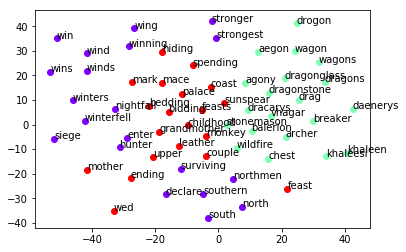

In [35]:
# we can even plot these vectors in space using t-SNE
# we've implemented this funciton for you for the sake of time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from gensim.models import FastText
import pandas as pd
from sklearn.manifold import TSNE

def plot_word_vectors(word_lists, model):
    all_words = [word for words in word_lists for word in words]
    
    X = [model.wv[word] for word in all_words]
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)
    
    df = pd.DataFrame(X_tsne, index=all_words, columns=['x', 'y'])
    
    dfs = [df.loc[words] for words in word_lists]
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    colors = cm.rainbow(np.linspace(0,1, len(dfs)))
    for df, color in zip(dfs, colors):
        ax.scatter(df['x'], df['y'], color=color)
    
    for df in dfs:
        for word, row in df.iterrows():
            plt.text(row['x'], row['y'], word)
    plt.show()

words = [
    [word for word, _ in model.wv.most_similar('winter', topn=20)],
    [word for word, _ in model.wv.most_similar('dragon', topn=20)],
    [word for word, _ in model.wv.most_similar('wedding', topn=20)],
]
plot_word_vectors(words, model)

#### What is lost with a dimensionality reduction technique?

Think about looking at this data set from different angles. 
![3d data](figures/3d-scatter-plot-rotate.gif)

When you're viewing high dimensional data in lower dimensions, you don't get the best idea for what's really happening. But it can be insightful.

### Searching for more than one word at a time

In [41]:
# gensim also allows you to search for multiple concepts
model.wv.most_similar(positive=['cow', 'hodor'])

[('bran', 0.45228421688079834),
 ('hot', 0.4430064558982849),
 ('coward', 0.4139120876789093),
 ('tunnel', 0.40595322847366333),
 ('alright', 0.4031175374984741),
 ('sick', 0.3821239471435547),
 ('brans', 0.37847551703453064),
 ('shhh', 0.3486930727958679),
 ('weep', 0.34808221459388733),
 ('load', 0.34524261951446533)]

How does it know what to pull back for more than one word?

It takes an average of the vectors provided in the list of positive objects. 

v1: [-0.91064538 -3.86880606]
v2: [2.87127439 1.47859433]
avg_v: [ 0.98031451 -1.19510587]


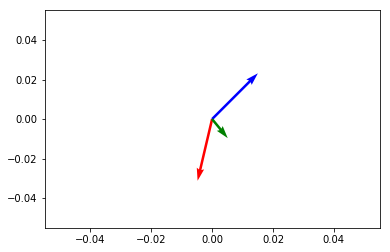

In [38]:
# let's show this in 2 dimensions
v1 = np.random.uniform(low=-5, high=5, size=2)
v2 = np.random.uniform(low=-5, high=5, size=2)
print(f"v1: {v1}")
print(f"v2: {v2}")

avg_v = np.average([v1, v2], axis=0)
print(f"avg_v: {avg_v}")

V = [v1, v2, avg_v]

# let's plot these vectors using matplotlib
plt.quiver(v1[0], v1[1], color='r', scale=21)
plt.quiver(v2[0], v2[0], color='b', scale=21)
plt.quiver(avg_v[0], avg_v[1], color='g', scale=21)
plt.show()

Does the average vector always look like it's it in the right spot? 

There may be a better function to use, but gensim implemented it this way. 

When two vectors are close together, this functionality makes a lot of sense. Find the word most similar to the average of these two words. But when two vectors are pointing in opposite directions, the average would be the origin, something kind of far away from both of those vectors. When giving examples, make sure your examples are similar enough to get reasonable results. 

Gensim also offers the ability to include negative examples

In fact, there are many papers publishing results from training word embeddings with such fantastic examples as `"king" - "man" + "woman" ≈ "queen"`. Let's see how this work on our data set. 

In [42]:
# implement the analogy by using 'king' and 'woman' in the positive params
# and 'man' in the negative param
model.wv.most_similar(positive=['king', 'woman'], negative=['man'])

[('womans', 0.5244296193122864),
 ('queen', 0.47971272468566895),
 ('woman’s', 0.4553077816963196),
 ('kingswood', 0.4486011266708374),
 ('protector', 0.426593154668808),
 ('romantic', 0.4167078137397766),
 ('kin', 0.412130743265152),
 ('warden', 0.4029715657234192),
 ('kingslayer', 0.3997613191604614),
 ('hoster', 0.39826256036758423)]

This result is amazing (and famous).

![analogies](figures/king-queen-analogy.png)

But does it always work?

In [43]:
# try a couple other anologies to see if they work!
# here's one to get you started 
model.wv.most_similar(positive=['jaime', 'arya'], negative=['lannister'])

[('aryas', 0.5943311452865601),
 ('sansas', 0.3945685625076294),
 ('m', 0.3928951621055603),
 ('sansa', 0.38353633880615234),
 ('jaw', 0.3731205463409424),
 ('t', 0.3716163635253906),
 ('bran', 0.36177492141723633),
 ('attacks', 0.3606579303741455),
 ('horseback', 0.35282498598098755),
 ('attack', 0.3484230935573578)]

In [45]:
# can you find an analogy that works?
model.wv.most_similar(positive=['soup'], negative=['spoon'])

[('sow', 0.4693673253059387),
 ('sour', 0.46184128522872925),
 ('sounds', 0.45900145173072815),
 ('southern', 0.4528665244579315),
 ('song', 0.44896772503852844),
 ('souls', 0.44535064697265625),
 ('south', 0.44462788105010986),
 ('southerners', 0.43650391697883606),
 ('sound', 0.41304874420166016),
 ('carriage', 0.3958780765533447)]

Not as much luck in other analogy examples.

This [paper](https://kawine.github.io/blog/nlp/2019/06/21/word-analogies.html) proves the conditions necessary for these incredible analogies to work. In short, more data likely solves this problem. 

![When analogies work](figures/when-analogies-work.png)


In research, we've tried to figure out the best way to incorporate negative examples into our searches, but we just haven't found a consistently useful result. We also aren't using our word embeddings for analogies, so we don't want to get too hung up on this. 

In [46]:
# let's save our model for further use
# create the directory 'models'
# and save the model as 'got_ft.model'

save_path = os.path.join('models', 'got_ft.model')
if not os.path.isdir('models'):
    os.mkdir('models')
model.save(save_path)


### Other values of word embeddings coming from automatically transcribed speech data

- we capture aliases! 
- we get tons of insight from the specific context of call centers

# Summary - What did we learn today?
- ways of training word embeddings
    - raw counts from the data
        - can't handle out-of-vocab words
        - captures contextually similar words
    - neural methods: FastText
        - captures character similarities as well as contextual similarities
- how to use word embeddings
    - find similar words
    - search for more than one word at a time
    - search for "a", and "b", but not like "c" with questionable results

In [48]:
# let's review our dictionary of new terms
from pprint import pprint
pprint(d)

{'distance metric': 'how to measure the space between two vectors',
 'distributional hypothesis': 'linguistic items with '
                              'similar                                 '
                              'distributions have similar meanings',
 'distributional semantics': 'linguistic theory that relies '
                             'on                                 dist. '
                             'hypothesis',
 'homograph': 'words that are spelled the same but have '
              'different                      meaning',
 'semi-supervised learning': 'collection of ML '
                             'algorithms                                  that '
                             "use data that 'labels "
                             "itself'                                  or "
                             'unlabeled data',
 'sparse vector': 'too many 0s',
 'word embedding': 'a low dimensional vector that '
                   'represents                     

# Survey !!!

Please complete the [course survey](https://forms.office.com/Pages/ResponsePage.aspx?id=gwv7BWBlfUGFbTjusOst_QYpnoW2nrtJmgVZLQ3gu25UMURGMDdaUTA0QUhJQTM3NlMxNE9GVVkyRC4u)